In [ ]:
#Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Step 1: Load and Clean Dataset
df = pd.read_csv(r'C:\Users\SRINIVAS\Downloads\online_retail.csv', encoding='ISO-8859-1')
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [5]:

# Step 2: RFM Feature Engineering
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


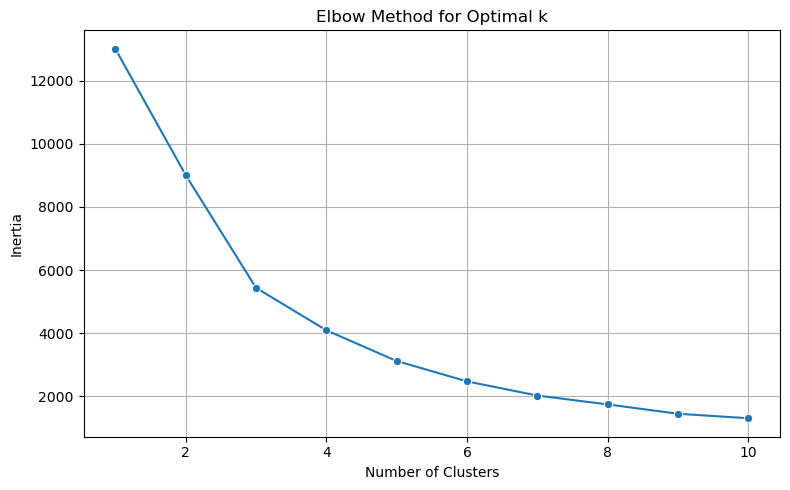

In [6]:
# Step 3: Normalize RFM and Elbow Method
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(range(1, 11)), y=inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Step 4: Apply KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)



In [8]:
# Step 5: Label Segments
def label_cluster(row):
    if row['Recency'] <= 50 and row['Frequency'] >= 5 and row['Monetary'] >= 1000:
        return 'High-Value'
    elif row['Recency'] > 100 and row['Frequency'] <= 2 and row['Monetary'] < 500:
        return 'At-Risk'
    elif row['Frequency'] >= 3 and row['Monetary'] >= 500:
        return 'Regular'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(label_cluster, axis=1)


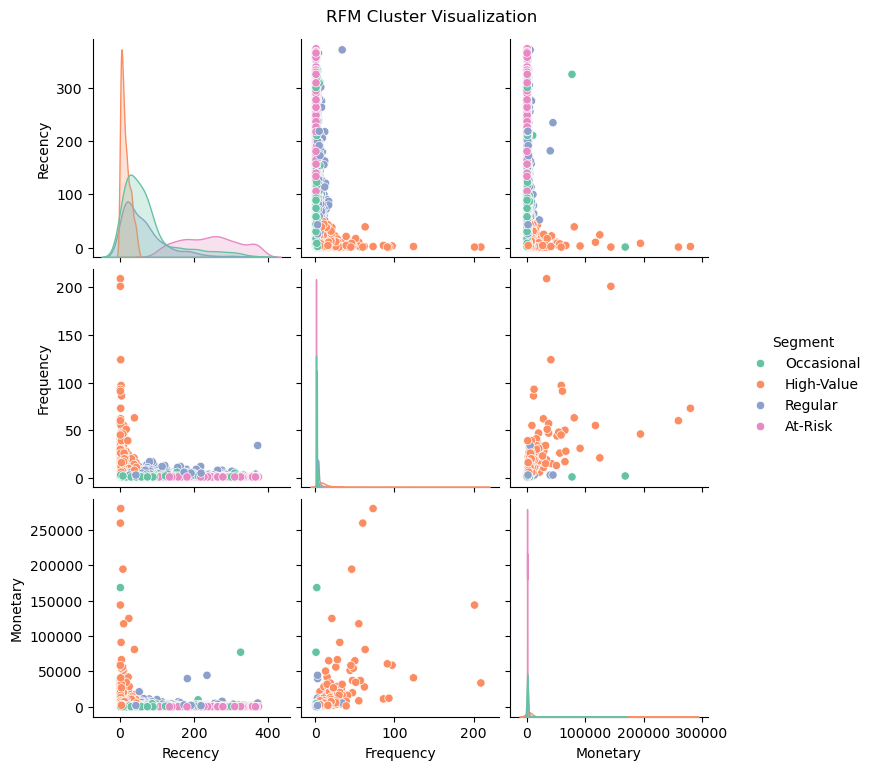

In [9]:
# Step 6: Visualize Clusters
sns.pairplot(rfm.reset_index(), hue='Segment', vars=['Recency', 'Frequency', 'Monetary'], palette='Set2')
plt.suptitle('RFM Cluster Visualization', y=1.02)
plt.show()


In [10]:
# Step 7: Collaborative Filtering - Item-Based Recommendation
pivot_table = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum').fillna(0)
sim_matrix = pd.DataFrame(cosine_similarity(pivot_table.T),
                          index=pivot_table.columns, columns=pivot_table.columns)

def get_similar_products(product_name, top_n=5):
    if product_name in sim_matrix:
        return sim_matrix[product_name].sort_values(ascending=False)[1:top_n+1]
    else:
        return f"'{product_name}' not found in product list."

In [11]:
# Example usage:
print("\nRecommended products for 'WHITE HANGING HEART T-LIGHT HOLDER':")
print(get_similar_products('WHITE HANGING HEART T-LIGHT HOLDER'))


Recommended products for 'WHITE HANGING HEART T-LIGHT HOLDER':
Description
GIN + TONIC DIET METAL SIGN         0.750410
RED HANGING HEART T-LIGHT HOLDER    0.658719
WASHROOM METAL SIGN                 0.643500
LAUNDRY 15C METAL SIGN              0.642206
GREEN VINTAGE SPOT BEAKER           0.631461
Name: WHITE HANGING HEART T-LIGHT HOLDER, dtype: float64


In [12]:
# Optional: Save Models for Streamlit App
import pickle
pickle.dump(kmeans, open('rfm_kmeans_model.pkl', 'wb'))
pickle.dump(scaler, open('rfm_scaler.pkl', 'wb'))
sim_matrix.to_pickle('product_similarity_matrix.pkl')
